In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [19]:
image_res = 256

image_center_x = 0.5
image_center_y = 0
zoom_factor = 0.5

init_center = 0
init_range = 1

token_length = 4
tokenizer_embedding_size = 768

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2 + token_length * tokenizer_embedding_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 3)
        
        nn.init.uniform_(self.fc1.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc2.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc3.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc4.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc5.weight, a=-init_range, b=init_range)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.sigmoid((self.fc5(x)))
        
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=3074, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=3, bias=True)
)

In [4]:
loss = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0000005)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def tokenize(text, fixed_length):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    
    if len(tokens) > fixed_length:
        tokens = tokens[:fixed_length]
    else:
        tokens += [0] * (fixed_length - len(tokens))

    tokens_tensor = torch.tensor([tokens])

    outputs = model.get_input_embeddings()(tokens_tensor)

    return outputs[0].flatten().detach()

In [6]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return torch.tensor(img_array, dtype=torch.float32, device=GPU)

In [7]:
def display_image(img_array):
    img_array = np.array(img_array)
    plt.imshow(img_array)
    plt.show()

In [8]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    calc_loss = loss(outputs, answer_tensor)
    calc_loss.backward()
    optimizer.step()

In [9]:
def get_net_ip(text):
    tokenized = tokenize(text, token_length)
    
    coords = torch.meshgrid((torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 - image_center_y) * zoom_factor,
                            (torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 + image_center_x) * zoom_factor)
    
    coords = torch.stack(coords, dim=-1)
    
    with_tokens = torch.zeros(image_res, image_res, 2 + token_length * tokenizer_embedding_size, dtype=torch.float32, device=GPU)
    
    with_tokens[:, :, :token_length * tokenizer_embedding_size] = tokenized.repeat(image_res, image_res, 1)
    with_tokens[:, :, token_length * tokenizer_embedding_size:] = coords
    
    return with_tokens

In [10]:
def get_img_array(text):
    image = net(get_net_ip(text))
    return image

In [11]:
dir1 = r"C:\Users\user\Desktop\learning from human\images\squares"
dir2 = r"C:\Users\user\Desktop\learning from human\images\triangles"
tok1 = "green square"
tok2 = "red triangle"
files1 = os.listdir(dir1)
files2 = os.listdir(dir2)

questions = []
answers = []

for x in tqdm(range(len(files1))):
    img1 = load_image(fr"{dir1}\{files1[x]}")
    img2 = load_image(fr"{dir2}\{files2[x]}")
    
    answers.append(img1)
    answers.append(img2)
    
    questions.append(get_net_ip(tok1))
    questions.append(get_net_ip(tok2))

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10/10 [00:00<00:00, 18.45it/s]


In [12]:
for y in tqdm(range(1000)):
    for x in (range(len(questions))):
        train_nn(questions[x], answers[x], net)

100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


these 2 images are the 'original' images, so in resolution: 32x32, the resolution that the network was trained on.


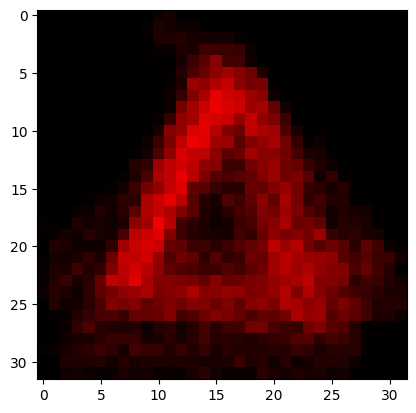

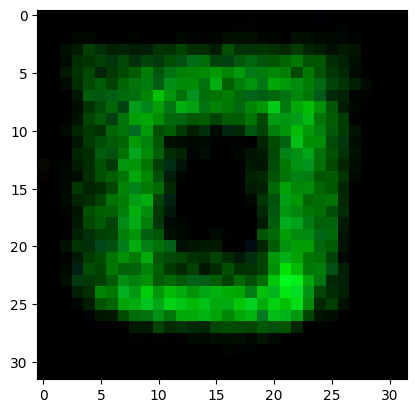

In [18]:
print("these 2 images are the 'original' images, so in resolution: 32x32, the resolution that the network was trained on.")
display_image(get_img_array("red triangle").detach().cpu())
display_image(get_img_array("green square").detach().cpu())

these are the two upscaled ones:


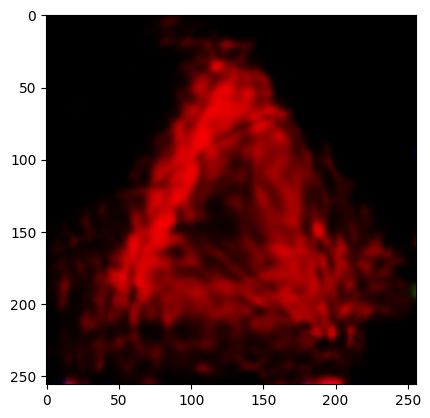

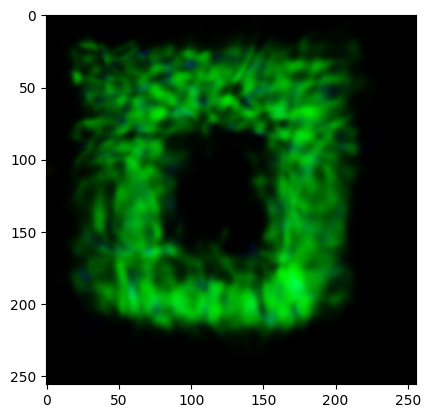

In [20]:
print("these are the two upscaled ones:")
display_image(get_img_array("red triangle").detach().cpu())
display_image(get_img_array("green square").detach().cpu())